## Import Modules

In [1]:
#import modules
from statsbombpy import sb

import pandas as pd
import matplotlib.pyplot as plt
import json

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier

import numpy as np
import math
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
from bs4 import BeautifulSoup
import requests

## Define specialized variables

In [3]:
match_week_stage = math.floor((3/4)*38)
print(match_week_stage)

28


## Obtain League and shots data from Statsbomb

In [4]:
competitions = sb.competitions()

In [5]:
#events.columns

In [6]:
competitions[
    (competitions['competition_name'].isin([
    'Premier League', '1. Bundesliga', 'La Liga', 'Ligue 1', 'Serie A']))
             & 
    (competitions['season_name']=='2015/2016')
            ]

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2023-12-12T07:43:33.436182,None,None,2023-12-12T07:43:33.436182
41,11,27,Spain,La Liga,male,False,False,2015/2016,2023-09-20T17:21:32.111535,2021-06-13T16:17:31.694,None,2023-09-20T17:21:32.111535
58,7,27,France,Ligue 1,male,False,False,2015/2016,2023-12-13T00:27:57.162379,None,None,2023-12-13T00:27:57.162379
62,2,27,England,Premier League,male,False,False,2015/2016,2023-11-14T11:25:33.476498,2021-06-13T16:17:31.694,None,2023-11-14T11:25:33.476498
64,12,27,Italy,Serie A,male,False,False,2015/2016,2023-12-13T17:32:46.423081,None,None,2023-12-13T17:32:46.423081


In [7]:
#competitions[competitions['competition_name']=='Champions League']

In [8]:
SerieA = sb.matches(competition_id=12, season_id=27)
SerieA.head()

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3879863,2016-05-08,15:00:00.000,Italy - Serie A,2015/2016,Atalanta,Udinese,1,1,available,...,None,37,Regular Season,Gewiss Stadium,Nicola Rizzoli,Edoardo Reja,Luigi De Canio,1.1.0,2,2
1,3879773,2016-03-06,16:00:00.000,Italy - Serie A,2015/2016,Frosinone,Udinese,2,0,available,...,None,28,Regular Season,Stadio Comunale Matusa,Nicola Rizzoli,Roberto Stellone,Stefano Colantuono,1.1.0,2,2
2,3879847,2016-04-30,18:00:00.000,Italy - Serie A,2015/2016,Udinese,Torino,1,5,available,...,None,36,Regular Season,Dacia Arena,Maurizio Mariani,Luigi De Canio,Gian Piero Ventura\t,1.1.0,2,2
3,3879862,2016-05-08,20:45:00.000,Italy - Serie A,2015/2016,Torino,Napoli,1,2,available,...,None,37,Regular Season,Stadio Olimpico Grande Torino,Antonio Damato,Gian Piero Ventura\t,Maurizio Sarri,1.1.0,2,2
4,3879817,2016-04-16,20:45:00.000,Italy - Serie A,2015/2016,Inter Milan,Napoli,2,0,available,...,None,33,Regular Season,Stadio Giuseppe Meazza,Gianluca Rocchi,Roberto Mancini,Maurizio Sarri,1.1.0,2,2


In [9]:
SerieA.columns

Index(['match_id', 'match_date', 'kick_off', 'competition', 'season',
       'home_team', 'away_team', 'home_score', 'away_score', 'match_status',
       'match_status_360', 'last_updated', 'last_updated_360', 'match_week',
       'competition_stage', 'stadium', 'referee', 'home_managers',
       'away_managers', 'data_version', 'shot_fidelity_version',
       'xy_fidelity_version'],
      dtype='object')

In [10]:
print(pd.unique(SerieA['home_team']))

['Atalanta' 'Frosinone' 'Udinese' 'Torino' 'Inter Milan' 'Lazio' 'AS Roma'
 'Sassuolo' 'AC Milan' 'Sampdoria' 'Napoli' 'Juventus' 'Hellas Verona'
 'Bologna' 'Palermo' 'Fiorentina' 'Genoa' 'Empoli' 'Carpi' 'Chievo']


In [11]:
SerieA.iloc[0]

match_id                                    3879863
match_date                               2016-05-08
kick_off                               15:00:00.000
competition                         Italy - Serie A
season                                    2015/2016
home_team                                  Atalanta
away_team                                   Udinese
home_score                                        1
away_score                                        1
match_status                              available
match_status_360                        unscheduled
last_updated             2023-07-24T07:00:20.863653
last_updated_360                               None
match_week                                       37
competition_stage                    Regular Season
stadium                              Gewiss Stadium
referee                              Nicola Rizzoli
home_managers                          Edoardo Reja
away_managers                        Luigi De Canio
data_version

In [12]:
example = sb.events(match_id=3754037)
example.columns

Index(['ball_receipt_outcome', 'ball_recovery_offensive',
       'ball_recovery_recovery_failure', 'carry_end_location',
       'clearance_aerial_won', 'clearance_body_part', 'clearance_head',
       'clearance_left_foot', 'clearance_right_foot', 'counterpress',
       'dribble_nutmeg', 'dribble_outcome', 'dribble_overrun', 'duel_outcome',
       'duel_type', 'duration', 'foul_committed_advantage',
       'foul_committed_card', 'foul_committed_offensive',
       'foul_committed_type', 'foul_won_advantage', 'foul_won_defensive',
       'goalkeeper_body_part', 'goalkeeper_end_location', 'goalkeeper_outcome',
       'goalkeeper_position', 'goalkeeper_technique', 'goalkeeper_type', 'id',
       'index', 'interception_outcome', 'location', 'match_id', 'minute',
       'miscontrol_aerial_won', 'off_camera', 'out', 'pass_aerial_won',
       'pass_angle', 'pass_assisted_shot_id', 'pass_body_part', 'pass_cross',
       'pass_cut_back', 'pass_end_location', 'pass_goal_assist', 'pass_height',
   

In [13]:
#example[(example['type']=='Shot') & (example['under_pressure']==True)]
#example[example['type']=='Shot']
#example[(example['type']=='Shot') & (example['goalkeeper_position']=='Moving')]
#example[example['type']=='Shot']['goalkeeper_position']
example[example['type']=='Shot']['goalkeeper_end_location']
#example[example['type']=='Shot']['under_pressure']
#pd.unique(example['type'])

3814    NaN
3815    NaN
3816    NaN
3817    NaN
3818    NaN
3819    NaN
3820    NaN
3821    NaN
3822    NaN
3823    NaN
3824    NaN
3825    NaN
3826    NaN
3827    NaN
3828    NaN
3829    NaN
3830    NaN
3831    NaN
3832    NaN
3833    NaN
3834    NaN
3835    NaN
3836    NaN
3837    NaN
3838    NaN
3839    NaN
3840    NaN
Name: goalkeeper_end_location, dtype: object

In [14]:
relevant_attributes = ['minute', 'second', 'team', 'shot_statsbomb_xg',
                       'player', 'position', 'location', 'shot_body_part',
       'shot_end_location', 'shot_first_time', 
         'shot_technique',
       'shot_type', 'type','shot_outcome', 'under_pressure']

## Obtain dataframe of all shots up to our matchweek stage

In [15]:
SerieA_shots_df = pd.DataFrame(columns=relevant_attributes)

In [16]:
start = time.time()
for match in SerieA[SerieA['match_week']<=match_week_stage]['match_id']:
    match_df = sb.events(match_id=match)
    relevant_match_df = match_df[relevant_attributes][match_df['type']=='Shot']
    SerieA_shots_df = pd.concat([SerieA_shots_df, relevant_match_df], ignore_index=True)

SerieA_shots_df['shot_outcome'] = SerieA_shots_df['shot_outcome'].replace(
    to_replace={'Off T': 0, 'Blocked': 0, 'Saved': 0, 'Goal': 1, 'Wayward': 0, 'Post': 0,
               'Saved to Post': 0, 'Saved Off Target': 0})

SerieA_shots_df['distance'] = SerieA_shots_df.apply(lambda row: np.sqrt(np.abs(
    row.location[0]-120)**2 + np.abs(row.location[1]-40)**2), axis=1)
SerieA_shots_df['shot_angle'] = SerieA_shots_df.apply(
    lambda row: np.arctan2(np.abs(40-row.location[1]), np.abs(120-row.location[0])), axis=1)
end = time.time()
print(f'script run time: {(end - start)/60} minutes')
SerieA_shots_df

script run time: 4.769219748179117 minutes


,minute,second,team,shot_statsbomb_xg,player,position,location,shot_body_part,shot_end_location,shot_first_time,shot_technique,shot_type,type,shot_outcome,under_pressure,distance,shot_angle
0,2,17,Frosinone,0.024742,Oliver Kragl,Left Midfield,"[95.6, 33.5]",Left Foot,"[108.0, 43.6]",True,Volley,Open Play,Shot,0,NaN,25.250941,0.260347
1,11,53,Frosinone,0.045061,Daniel Ciofani,Right Center Forward,"[99.0, 31.3]",Right Foot,"[120.0, 37.0, 0.9]",NaN,Normal,Open Play,Shot,1,True,22.730816,0.392761
2,20,54,Udinese,0.026071,Emmanuel Agyemang-Badu,Right Center Midfield,"[94.8, 52.3]",Right Foot,"[120.0, 42.2, 5.9]",NaN,Normal,Open Play,Shot,0,NaN,28.041576,0.454079
3,21,37,Frosinone,0.033250,Daniel Ciofani,Right Center Forward,"[101.6, 25.6]",Right Foot,"[120.0, 41.9, 4.0]",NaN,Normal,Open Play,Shot,0,NaN,23.364931,0.664046
4,28,58,Frosinone,0.031600,Federico Dionisi,Left Center Forward,"[95.6, 47.1]",Left Foot,"[120.0, 36.5, 4.2]",True,Normal,Open Play,Shot,0,NaN,25.412005,0.283164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7344,89,37,Lazio,0.030999,Danilo Cataldi,Center Defensive Midfield,"[98.6, 40.4]",Left Foot,"[99.8, 40.4]",NaN,Normal,Open Play,Shot,0,True,21.403738,0.018689
7345,90,22,Bologna,0.042634,Franco Brienza,Center Attacking Midfield,"[103.0, 51.3]",Left Foot,"[111.5, 44.2]",True,Normal,Open Play,Shot,0,NaN,20.412986,0.586644
7346,90,24,Bologna,0.038101,Franco Brienza,Center Attacking Midfield,"[103.8, 51.4]",Right Foot,"[109.6, 40.9]",True,Half Volley,Open Play,Shot,0,NaN,19.809089,0.613207
7347,90,25,Bologna,0.063746,Matteo Brighi,Right Center Midfield,"[110.0, 39.4]",Head,"[116.8, 40.9, 2.0]",NaN,Normal,Open Play,Shot,0,NaN,10.017984,0.059928


## Describing the Data

In [17]:
SerieA_shots_df.describe()

,shot_statsbomb_xg,shot_outcome,distance,shot_angle
count,7349.000000,7349.000000,7349.000000,7349.000000
mean,0.090421,0.094026,20.518900,0.464634
std,0.136604,0.291885,8.890550,0.315772
min,0.000180,0.000000,1.414214,0.000000
25%,0.024229,0.000000,13.164346,0.201801
50%,0.044289,0.000000,20.359273,0.427735
75%,0.088275,0.000000,27.069725,0.681298
max,0.966261,1.000000,88.833158,1.570796


In [18]:
SerieA_shots_df = SerieA_shots_df[SerieA_shots_df.shot_type != 'Corner']

In [19]:
SerieA_shots_df['shot_outcome'].value_counts()

shot_outcome
0    6657
1     690
Name: count, dtype: int64

In [20]:
SerieA_team_summary_df = pd.DataFrame(columns = ['team', 'shots', 'goals', 'statsbomb_xg', 'xg_overperformance'])
for team in pd.unique(SerieA_shots_df['team']):
    shot_sum = SerieA_shots_df['team'].value_counts()[team]
    goal_sum = sum(SerieA_shots_df[SerieA_shots_df['team']==team]['shot_outcome'])
    statsbomb_xg_sum = sum(SerieA_shots_df[SerieA_shots_df['team']==team]['shot_statsbomb_xg'])
    xg_overperformance = goal_sum - statsbomb_xg_sum
    new_row = pd.Series({'team': team, 'shots': shot_sum, 'goals': goal_sum, 'statsbomb_xg': statsbomb_xg_sum, 'xg_overperformance': xg_overperformance})
    SerieA_team_summary_df.loc[len(SerieA_team_summary_df)]=new_row
SerieA_team_summary_df = SerieA_team_summary_df.sort_values(by=['goals'], ascending=False)
totals_row = pd.Series({'team': 'Totals',
                        'shots': sum(SerieA_team_summary_df['shots']),
                        'goals': sum(SerieA_team_summary_df['goals']),
                        'statsbomb_xg': sum(SerieA_team_summary_df['statsbomb_xg']),
                        'xg_overperformance': sum(SerieA_team_summary_df['xg_overperformance'])})
SerieA_team_summary_df.loc[len(SerieA_team_summary_df)]=totals_row
SerieA_team_summary_df

,team,shots,goals,statsbomb_xg,xg_overperformance
4,AS Roma,419,59,44.978814,14.021186
10,Napoli,486,56,45.401721,10.598279
3,Fiorentina,405,48,40.503415,7.496585
13,Juventus,445,47,44.210445,2.789555
8,Sampdoria,333,40,32.783598,7.216402
9,AC Milan,407,39,37.094893,1.905107
16,Inter Milan,380,36,35.370341,0.629659
6,Sassuolo,369,35,32.141447,2.858553
12,Lazio,382,35,33.192312,1.807688
5,Empoli,388,32,27.12764,4.87236


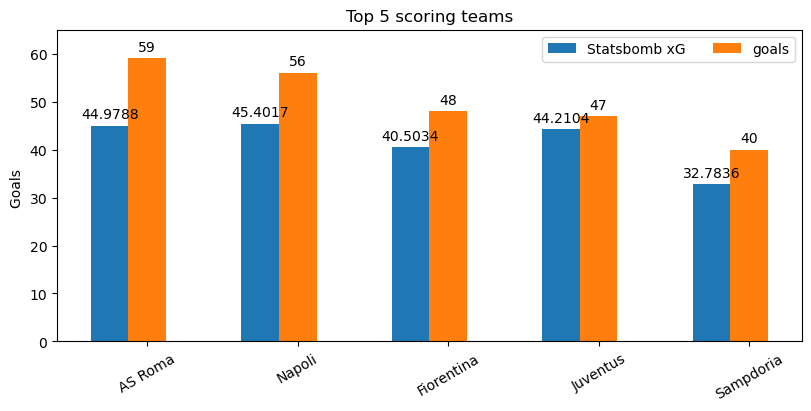

In [21]:
teams = SerieA_team_summary_df['team'][0:5]
team_goals = {
    'Statsbomb xG': SerieA_team_summary_df['statsbomb_xg'][0:5].round(),
    'goals': SerieA_team_summary_df['goals'][0:5].round(),
}

x = np.arange(len(teams))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(8,4))

for attribute, measurement in team_goals.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Goals ')
ax.set_title('Top 5 scoring teams')
ax.set_xticks(x + width, teams)
ax.legend(loc='upper right', ncols=2)
ax.set_ylim(0, 65)
ax.tick_params(axis='x', rotation=30)
plt.show()

In [22]:
SerieA_shots_df.columns

Index(['minute', 'second', 'team', 'shot_statsbomb_xg', 'player', 'position',
       'location', 'shot_body_part', 'shot_end_location', 'shot_first_time',
       'shot_technique', 'shot_type', 'type', 'shot_outcome', 'under_pressure',
       'distance', 'shot_angle'],
      dtype='object')

## Split training and test data, train model and define functions

In [25]:
cap_x_df, y_df = pd.concat([SerieA_shots_df.iloc[:,:-4], SerieA_shots_df.iloc[:,-3:]], axis=1),SerieA_shots_df.iloc[:,-4].to_frame()

In [26]:
train_cap_x_df, test_cap_x_df, train_y_df, test_y_df = \
train_test_split(cap_x_df, y_df,
                 test_size=0.20,
                random_state=42,
                 shuffle=True,
                stratify=y_df)

In [27]:
target_attr = 'shot_outcome'

In [28]:
numerical_attrs = ['distance', 'minute', 'shot_angle']

In [29]:
nominal_attrs = ['shot_technique', 'shot_type', 'shot_body_part', 'position', 'shot_first_time', 'under_pressure']

In [30]:
numerical_transformer = Pipeline(
        steps=[("imputer", SimpleImputer()),
               ("scaler", StandardScaler())]
    )

In [31]:
nominal_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="constant", fill_value=False)),
               ('target_encoder', TargetEncoder(target_type='auto', random_state=42)),
               #("target_encoder", OrdinalEncoder()),
               ("scaler", StandardScaler())
               ]
    )

In [32]:
preprocessor = ColumnTransformer(
        transformers=[
            ('numerical', numerical_transformer, numerical_attrs),
            ('nominal', nominal_transformer, nominal_attrs)
        ]
    )

### The function below will be used to compare our models to the statsbomb model

In [33]:
def plot_comparison(model1, model1_name, model2, model2_name, outcome):
    plt.figure()
    df = pd.DataFrame({'model1':model1,'model2':model2,'outcome':outcome})
    no_goal = df[df['outcome']==0]
    plt.scatter(no_goal['model1'],no_goal['model2'], label='no goal', color='blue', alpha=0.6)
    goal = df[df['outcome']==1]
    plt.scatter(goal['model1'],goal['model2'], label='goal', color='orange', alpha=1)
    #plt.scatter(model1, model2,c=outcome)
    plt.xlabel(model1_name)
    plt.ylabel(model2_name)
    plt.xlim(0,1.1)
    plt.ylim(0,1.1)
    plt.legend()
    z = np.polyfit(model1, model2,1)
    #z = np.polyfit(df['model1'], df['model2'],1)
    p = np.poly1d(z)
    plt.plot(model1, p(model1),"r--")
    #plt.plot(df['model1'], p(df['model1']),"r--")
    print(model1_name)
    print("y=%.2fx+%.2f"%(z[0],z[1]))
    print("$R^2$=", r2_score(model1,model2))

## Train our estimators

LogisticRegression
y=1.04x+-0.01
$R^2$= 0.35560051917358504
SGDClassifier
y=0.88x+0.00
$R^2$= 0.4251426008524005
RandomForestClassifier
y=0.74x+0.02
$R^2$= 0.6069226806803454
GradientBoostingClassifier
y=0.89x+0.01
$R^2$= 0.681103732434007
DecisionTreeClassifier
y=0.22x+0.07
$R^2$= 0.1800808348169579


,shots,goals,statsbomb_xg,LogisticRegression,SGDClassifier,RandomForestClassifier,GradientBoostingClassifier,DecisionTreeClassifier
0,5877,552,533.712454,550.33309,580.793926,576.305333,551.332689,457.5


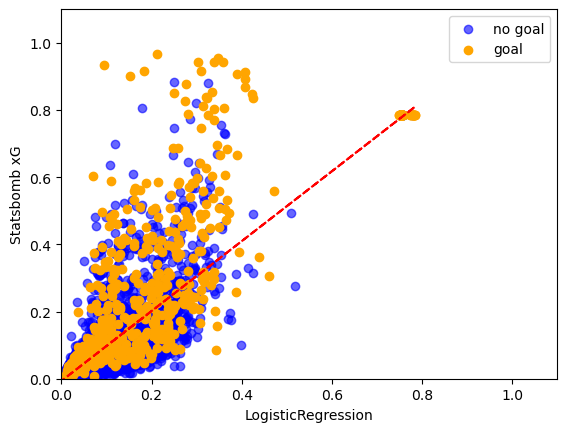

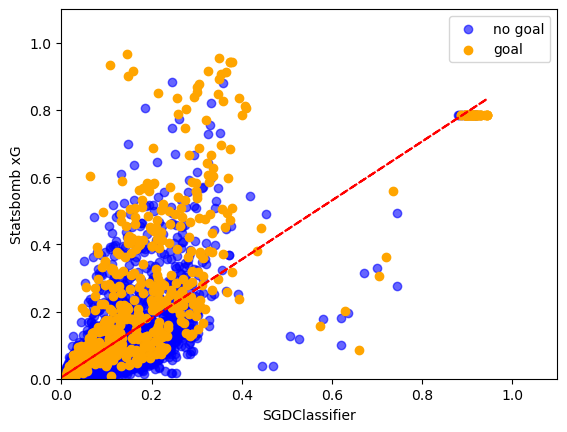

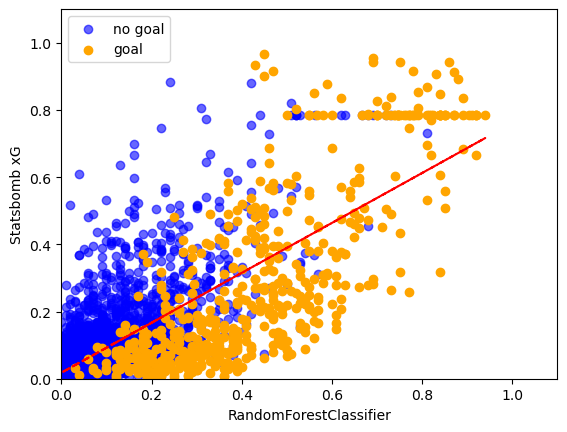

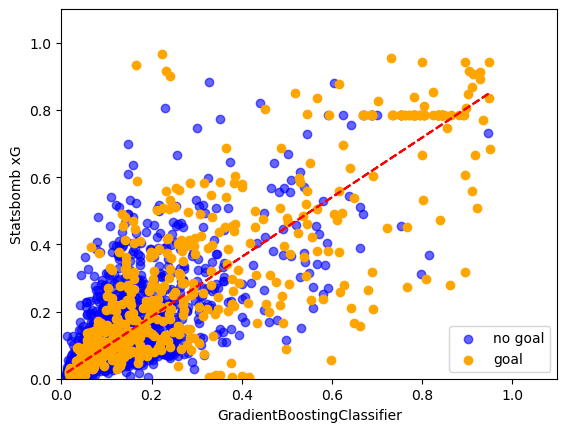

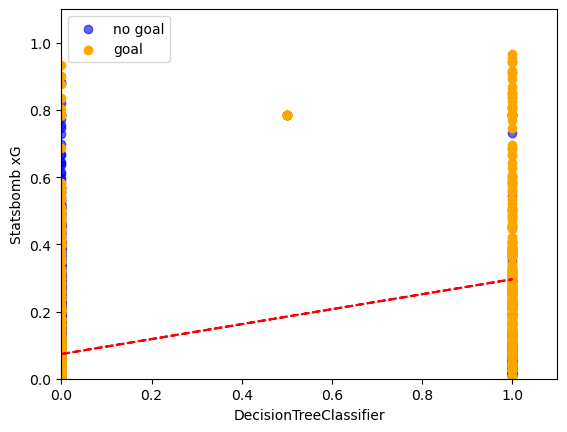

In [34]:
estimator_names = ['LogisticRegression', 'SGDClassifier', 'RandomForestClassifier', 
                  'GradientBoostingClassifier', 'DecisionTreeClassifier']

estimator_list = [LogisticRegression(), SGDClassifier(loss='log_loss'), 
                  RandomForestClassifier(criterion='log_loss'), GradientBoostingClassifier(loss='log_loss'),
                 DecisionTreeClassifier(criterion='log_loss')]
trained_estimator_dict = {}
#model_summary = pd.DataFrame(columns = ['shots', 'goals', 'statsbomb_xg']
model_summary = {}
model_summary['shots'] = [len(train_y_df[target_attr])]
model_summary['goals'] = [train_y_df[target_attr].value_counts()[1]]
model_summary['statsbomb_xg'] = [sum(train_cap_x_df['shot_statsbomb_xg'])]
for estimator_name, estimator in zip(estimator_names, estimator_list):
    composite_estimator = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', estimator)])
    trained_estimator_dict[estimator_name] = composite_estimator.fit(train_cap_x_df, train_y_df.values.ravel())
    predictions = trained_estimator_dict[estimator_name].predict_proba(train_cap_x_df)[:,1]
    SBModel = train_cap_x_df['shot_statsbomb_xg']
    shot_outcome = train_y_df[target_attr]
    model_summary[estimator_name] = [sum(predictions)]
    plot_comparison(predictions, estimator_name, SBModel, 'Statsbomb xG', shot_outcome)
#print(pd.DataFrame(model_summary))
pd.DataFrame.from_dict(model_summary)

## Select Best Model and examine Permutation Importance

In [35]:
best_model_name = 'GradientBoostingClassifier'
best_model = trained_estimator_dict[best_model_name]

In [36]:
feature_importances = permutation_importance(
    best_model, train_cap_x_df, train_y_df.values.ravel())

In [37]:
mean_feature_importances = pd.Series(feature_importances.importances_mean, index=train_cap_x_df.columns)
mean_feature_importances.sort_values(ascending=False)
std_feature_importances = pd.Series(feature_importances.importances_std, index=train_cap_x_df.columns)
std_feature_importances

minute               0.000500
second               0.000000
team                 0.000000
shot_statsbomb_xg    0.000000
player               0.000000
position             0.000563
location             0.000000
shot_body_part       0.000868
shot_end_location    0.000000
shot_first_time      0.000534
shot_technique       0.000469
shot_type            0.000394
type                 0.000000
under_pressure       0.000000
distance             0.001527
shot_angle           0.000640
dtype: float64

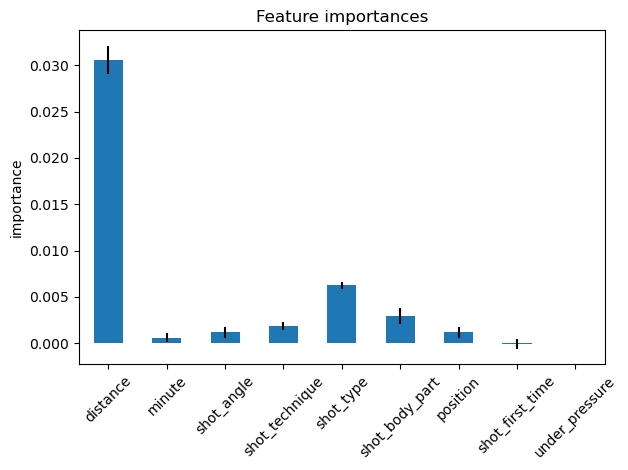

In [38]:
fig, ax = plt.subplots()
#mean_feature_importances[['distance','shot_body_part', 'shot_type', 'shot_angle']].plot.bar(
#    yerr=std_feature_importances[['distance','shot_body_part', 'shot_type', 'shot_angle']], ax=ax)
mean_feature_importances[numerical_attrs+nominal_attrs].plot.bar(
    yerr=std_feature_importances[numerical_attrs+nominal_attrs], ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("importance")
plt.xticks(rotation=45)
fig.tight_layout()
plt.show()

## Evaluate on Test Set

GradientBoostingClassifier
y=0.88x+0.01
$R^2$= 0.6872195494632827


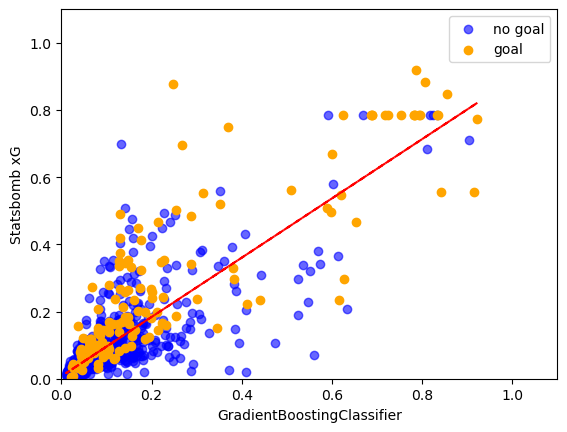

In [39]:
test_predictions = best_model.predict_proba(test_cap_x_df)[:,1]
test_SBModel = test_cap_x_df['shot_statsbomb_xg']
test_shot_outcome = test_y_df[target_attr]
plot_comparison(test_predictions, best_model_name, test_SBModel, 'Statsbomb xG', test_shot_outcome)

## Observe behavior on totality of test set

In [40]:
model_summary = pd.DataFrame(columns = ['shots', 'goals', 'statsbomb_xg', 'best_model_xg'])
shots = len(test_y_df[target_attr])
goals = test_y_df[target_attr].value_counts()[1]
statsbomb_xg = sum(test_cap_x_df['shot_statsbomb_xg'])
best_model_xg = sum(test_predictions)
new_row = pd.Series({'shots': shots, 'goals': goals, 'statsbomb_xg': statsbomb_xg, 'best_model_xg': best_model_xg})
model_summary.loc[len(model_summary)]=new_row
model_summary

,shots,goals,statsbomb_xg,best_model_xg
0,1470.0,138.0,130.793477,135.885862


## Examine on Week to Week basis
### Get matches for a particular team

In [41]:
def get_games_for_team(team):
    df = SerieA[(SerieA['home_team']==team)|(SerieA['away_team']==team)]
    df = df.sort_values(by='match_week')
    return df

In [42]:
AC_Milan_games = get_games_for_team('AC Milan')
AC_Milan_games

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
377,3878542,2015-08-23,20:45:00.000,Italy - Serie A,2015/2016,Fiorentina,AC Milan,2,0,available,...,None,1,Regular Season,Stadio Artemio Franchi \t,Paolo Valeri,Paulo Manuel Carvalho de Sousa,Siniša Mihajlović,1.1.0,2,2
368,3878551,2015-08-29,20:45:00.000,Italy - Serie A,2015/2016,AC Milan,Empoli,2,1,available,...,None,2,Regular Season,Stadio Giuseppe Meazza,Piero Giacomelli,Siniša Mihajlović,Marco Giampaolo,1.1.0,2,2
352,3878600,2015-09-13,20:45:00.000,Italy - Serie A,2015/2016,Inter Milan,AC Milan,1,0,available,...,None,3,Regular Season,Stadio Giuseppe Meazza,Gianluca Rocchi,Roberto Mancini,Siniša Mihajlović,1.1.0,2,2
350,3878602,2015-09-19,20:45:00.000,Italy - Serie A,2015/2016,AC Milan,Palermo,3,2,available,...,None,4,Regular Season,Stadio Giuseppe Meazza,Carmine Russo,Siniša Mihajlović,Giuseppe Iachini,1.1.0,2,2
346,3879537,2015-09-22,20:45:00.000,Italy - Serie A,2015/2016,Udinese,AC Milan,2,3,available,...,None,5,Regular Season,Dacia Arena,Daniele Doveri,Stefano Colantuono,Siniša Mihajlović,1.1.0,2,2
334,3879549,2015-09-27,12:30:00.000,Italy - Serie A,2015/2016,Genoa,AC Milan,1,0,available,...,None,6,Regular Season,Stadio Comunale Luigi Ferraris,Paolo Tagliavento,Gian Piero Gasperini,Siniša Mihajlović,1.1.0,2,2
26,3879562,2015-10-04,20:45:00.000,Italy - Serie A,2015/2016,AC Milan,Napoli,0,4,available,...,None,7,Regular Season,Stadio Giuseppe Meazza,Nicola Rizzoli,Siniša Mihajlović,Maurizio Sarri,1.1.0,2,2
320,3879568,2015-10-17,20:45:00.000,Italy - Serie A,2015/2016,Torino,AC Milan,1,1,available,...,None,8,Regular Season,Stadio Olimpico Grande Torino,Andrea Gervasoni,Gian Piero Ventura\t,Siniša Mihajlović,1.1.0,2,2
23,3879585,2015-10-25,15:00:00.000,Italy - Serie A,2015/2016,AC Milan,Sassuolo,2,1,available,...,None,9,Regular Season,Stadio Giuseppe Meazza,Gianluca Rocchi,Siniša Mihajlović,Eusebio Di Francesco,1.1.0,2,2
298,3879594,2015-10-28,21:45:00.000,Italy - Serie A,2015/2016,AC Milan,Chievo,1,0,available,...,None,10,Regular Season,Stadio Giuseppe Meazza,Gianpaolo Calvarese\t,Siniša Mihajlović,Rolando Maran,1.1.0,2,2


## Examine individual matches
We'll look at a match after matchweek 28, since all the matches before matchweek 28 are what are used to train the model.

In [43]:
next_game_week = 35

In [44]:
match = AC_Milan_games[AC_Milan_games['match_week']==next_game_week]['match_id'].iloc[0]

In [45]:
def cumulative_sums(array):
    return [sum(array[:i+1]) for i in range(len(array))]

In [64]:
def display_match_results_with_xG(league_df,match, display_shots=False, display_chart=False):
    match_shots_df = pd.DataFrame(columns=relevant_attributes)
    #print(match)
    home_team = league_df[league_df['match_id']==match]['home_team'].values[0]
    home_score = league_df[league_df['match_id']==match]['home_score'].values[0]
    away_team = league_df[league_df['match_id']==match]['away_team'].values[0]
    away_score = league_df[league_df['match_id']==match]['away_score'].values[0]

    match_df = sb.events(match_id=match)
    new_match_df = match_df[relevant_attributes][match_df['type']=='Shot']

    match_shots_df = pd.concat([match_shots_df, new_match_df], ignore_index=True)

    match_shots_df['shot_outcome'] = match_shots_df['shot_outcome'].replace(
        to_replace={'Off T': 0, 'Blocked': 0, 'Saved': 0, 'Goal': 1, 'Wayward': 0, 'Post': 0,
                   'Saved to Post': 0, 'Saved Off Target': 0})

    match_shots_df['distance'] = match_shots_df.apply(lambda row: np.sqrt(np.abs(
        row.location[0]-120)**2 + np.abs(row.location[1]-40)**2), axis=1)
    match_shots_df['shot_angle'] = match_shots_df.apply(
        lambda row: np.arctan2(np.abs(40-row.location[1]), np.abs(120-row.location[0])), axis=1)
    match_shots_df = match_shots_df.sort_values(by='minute')
    #print(match_shots_df.columns)
    cap_x_df = pd.concat([match_shots_df.iloc[:,:-4], 
                              match_shots_df.iloc[:,-3:]], axis=1)
    
    predictions = best_model.predict_proba(cap_x_df)[:,1]
    predictions_df = pd.DataFrame({'best_model': predictions})
    match_shots_df['best_model']= predictions_df
    
    home_shots_df = match_shots_df[match_shots_df['team']==home_team]
    away_shots_df = match_shots_df[match_shots_df['team']==away_team]

    home_cap_x_df = pd.concat([home_shots_df.iloc[:,:-5], 
                                home_shots_df.iloc[:,-4:]], axis=1)
    away_cap_x_df = pd.concat([away_shots_df.iloc[:,:-5], 
                                away_shots_df.iloc[:,-4:]], axis=1)
    #print(home_shots_df.columns)
    #print(home_cap_x_df.columns)
    
    home_predictions = home_cap_x_df['best_model']
    away_predictions = away_cap_x_df['best_model']
    
    home_total_best_model_xG = sum(home_predictions)
    away_total_best_model_xG = sum(away_predictions)
    home_statsbomb_xG = sum(home_cap_x_df['shot_statsbomb_xg'])
    away_statsbomb_xG = sum(away_cap_x_df['shot_statsbomb_xg'])
    if display_shots == True:
        display(match_shots_df)
    print("Proposed model")
    print("%s (%.2f) %.0f-%.0f (%.2f) %s" % (home_team, home_total_best_model_xG, home_score, away_score, away_total_best_model_xG, away_team))
    print("statsbomb xG")
    print("%s (%.2f) %.0f-%.0f (%.2f) %s" % (home_team, home_statsbomb_xG, home_score, away_score, away_statsbomb_xG, away_team))
    if display_chart==True:
        home_team_xg = [0]
        away_team_xg = [0]
        home_min = [0]
        away_min = [0]
        for x in range(len(match_shots_df)):
            if match_shots_df['team'][x] == home_team:
                home_team_xg.append(match_shots_df['best_model'][x])
                home_min.append(match_shots_df['minute'][x])
            if match_shots_df['team'][x] == away_team:
                away_team_xg.append(match_shots_df['best_model'][x])
                away_min.append(match_shots_df['minute'][x])
        home_cumulative_xg = cumulative_sums(home_team_xg)
        away_cumulative_xg = cumulative_sums(away_team_xg)

        fig, ax = plt.subplots(figsize= (10,5))
        plt.xticks([0,15,30,45,60,75,90])
        plt.xlabel("minute")
        plt.ylabel("model xG")
        plt.title("Cumulative xG by minute")
        home, = ax.step(x=home_min, y=home_cumulative_xg, label=home_team)
        away, = ax.step(x=away_min, y=away_cumulative_xg, label=away_team)
        ax.legend(handles=[home,away])
    #return match_shots_df

Index(['minute', 'second', 'team', 'shot_statsbomb_xg', 'player', 'position',
       'location', 'shot_body_part', 'shot_end_location', 'shot_first_time',
       'shot_technique', 'shot_type', 'type', 'shot_outcome', 'under_pressure',
       'distance', 'shot_angle', 'best_model'],
      dtype='object')
Index(['minute', 'second', 'team', 'shot_statsbomb_xg', 'player', 'position',
       'location', 'shot_body_part', 'shot_end_location', 'shot_first_time',
       'shot_technique', 'shot_type', 'type', 'under_pressure', 'distance',
       'shot_angle', 'best_model'],
      dtype='object')
Proposed model
Hellas Verona (3.40) 2-1 (1.17) AC Milan
statsbomb xG
Hellas Verona (2.88) 2-1 (1.63) AC Milan


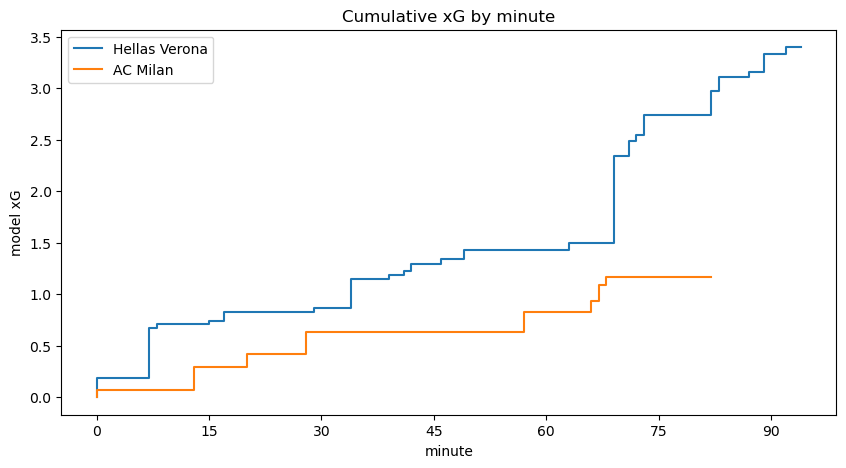

In [65]:
display_match_results_with_xG(AC_Milan_games,match, display_shots=False, display_chart=True)